# Denoising Diffusion Probababilistic Model

This tutorial will illustrate how you can train a diffusion model on your dataset. Many downstream applications of diffusion models involve training an unconditional diffusion first, before using such a model in a specialized prediction scheme, such as inpainting, denoising etc. Therefore, we will first show how to train an unconditional model and in a separate tutorial available [here], you can see an example of inpainting that also aims to illustrate what role UQ can potentially play.

## Theoretical Background

Numerous great introductions to diffusion models exist (linked below), so therefore we will only try to give a brief overview and intuition about this class of models.

## Imports

In [1]:
from torchgeo.transforms import AugmentationSequential
import torch
import kornia.augmentation as K
from lightning import LightningDataModule, Trainer
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from typing import Any
from glob import glob
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

from denoising_diffusion_pytorch.denoising_diffusion_pytorch import Unet, GaussianDiffusion

from lightning_uq_box.uq_methods import DDPM
import matplotlib.pyplot as plt


/opt/anaconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Implementation

Instead of implementing these models from scratch, we will utilize the implementations of this great [repo](https://github.com/lucidrains/denoising-diffusion-pytorch) by [lucidrains](https://lucidrains.github.io/), so please consider giving it a star to show your appreciation. The Lightning-UQ-Box provides LightningModule wrappers that execute the training via Lightning so you can benefit from all the multi-gpu and logging support that Lightning provides.

For the model we need three parts:
- the denoising model architecture, commonly a Unet
- the diffusion model that can execute the denoising step as well as sampling
- the diffusion LightningModule that can execute the training via lightning

The first two components are implemented in [denoising-diffusion-pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch) and the last one in the Lightning-UQ-Box.

In addition, we need a LightningDataModule that loads the images for our task.

### Unet

The available parameters of the model architecture mainly determine the size of the network. 

In [2]:
unet = Unet(
    dim=64,
    dim_mults=[1, 2, 4, 8],
    channels=3,
    self_condition=True
)

### Diffusion Model

In [3]:
diff_model = GaussianDiffusion(
    unet,
    image_size= 224,
    timesteps= 500,
    sampling_timesteps=250,
    beta_schedule="cosine"
)

**NOTE**

The more recent paper by [Karras et al 2022]() proposed some changes that can improve results. If you want to use that version, use `ElucidatedDiffusion` instead of `GaussianDiffusion` availabel as `from denoising_diffusion_pytorch.elucidated_diffusion import ElucidatedDiffusion`. For this implementation you also need to change the Unet architecture to either use `learned_sinusoidal_cond=True` or `random_fourier_features=True`.

### LightningModule

In [4]:
from hydra.utils import instantiate
from omegaconf import OmegaConf
config = OmegaConf.load("/mnt/SSD2/nils/ocean_bench_exps/diffusion/milliond_aid/million_aid_06-03-2024_07-15-35-401142/config.yaml")

diff_model = instantiate(config.model)



ddpm = DDPM(
    diff_model,
    log_samples_every_n_steps=200
)

In [5]:
state_dict = ddpm.state_dict()

for key in state_dict:
    print(key)

diffusion_model.diffusion_model.betas
diffusion_model.diffusion_model.alphas_cumprod
diffusion_model.diffusion_model.alphas_cumprod_prev
diffusion_model.diffusion_model.sqrt_alphas_cumprod
diffusion_model.diffusion_model.sqrt_one_minus_alphas_cumprod
diffusion_model.diffusion_model.log_one_minus_alphas_cumprod
diffusion_model.diffusion_model.sqrt_recip_alphas_cumprod
diffusion_model.diffusion_model.sqrt_recipm1_alphas_cumprod
diffusion_model.diffusion_model.posterior_variance
diffusion_model.diffusion_model.posterior_log_variance_clipped
diffusion_model.diffusion_model.posterior_mean_coef1
diffusion_model.diffusion_model.posterior_mean_coef2
diffusion_model.diffusion_model.loss_weight
diffusion_model.diffusion_model.model.init_conv.weight
diffusion_model.diffusion_model.model.init_conv.bias
diffusion_model.diffusion_model.model.time_mlp.1.weight
diffusion_model.diffusion_model.model.time_mlp.1.bias
diffusion_model.diffusion_model.model.time_mlp.3.weight
diffusion_model.diffusion_model.

### DataModule

For our purposes we will used the imagery of the [Million-Aid Dataset](https://captain-whu.github.io/DiRS/) that can also be loaded with [torchgeo](https://github.com/microsoft/torchgeo). The goal will be to train a model that can generate samples from the training data distribution.

In [6]:
class MillionAidDataset(VisionDataset):
    resize = K.Resize((224, 224))
    def __init__(self, root: str):
        super().__init__(root)

        self.fpaths = sorted(glob(root + '/*.jpg', recursive=True))
        assert len(self.fpaths) > 0, "File list is empty. Check the root."

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, index: int):
        fpath = self.fpaths[index]
        img = Image.open(fpath).convert('RGB')


        img = pil_to_tensor(img) / 255.
        img = (img).squeeze(0)

        return {"input": img}


class MillionAIDDataModule(LightningDataModule):
    """DataModule for MillionAID dataset."""

    def __init__(self, root: str, batch_size: int = 64, num_workers: int = 4):
        """Initialize a new instance of MillionAIDDataModule.
        
        Args:
            root: The root directory of the dataset.
            batch_size: The batch size.
            num_workers: The number of workers for the DataLoader.
        """
        super().__init__()

        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.aug = AugmentationSequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomVerticalFlip(p=0.5),
            data_keys=["input"],
        )

    def setup(self, stage: str | None = None):
        self.train = MillionAidDataset(root=self.root)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def on_after_batch_transfer(self, batch: dict[str, Any], dataloader_idx: int) -> dict[str, Any]:
        """Apply augmentations to the batch."""
        return self.aug(batch)

## Training

Training Diffusion Models is quiet computationally expensive. We have therefore pretrained a model to save a lot of time. However, the code below shows how you can train a model on your own dataset. In the included gif, you can see how the model capability to generate samples increases over training time, first random blobs and later samples that look like data points from our training distribution, namely the MillionAid dataset.

TODO: Include GIF here

In [7]:
LOAD_CKPT = True

In [8]:
dm = MillionAIDDataModule(root="/mnt/SSD2/nils/ocean_bench_exps/diffusion/data/million/test/test", batch_size=64, num_workers=4)

In [9]:
if not LOAD_CKPT:
    trainer = Trainer(
        accelerator="gpu",
        strategy="ddp",
        accumulate_grad_batches=4,
        devices=[4, 5, 6, 7],
        min_epochs=800,
        max_epochs=1000,
        log_every_n_steps=50,
        enable_progress_bar=True,
        enable_checkpointing=True
    )
    trainer.fit(ddpm, dm)

else:
    # load checkpoint from huggingface
    ckpt_path = "/mnt/SSD2/nils/ocean_bench_exps/diffusion/milliond_aid/million_aid_06-03-2024_07-15-35-401142/last.ckpt"
    state_dict = torch.load(ckpt_path, map_location="cuda:4")["state_dict"]
    new_state_dict = {}
    # for k, v in state_dict.items():
    #     if k.startswith("diffusion_model."):
    #         new_state_dict["diffusion_model."+k] = v
    #     elif k.startswith("ema.online_model."):
    #         new_state_dict["ema.ema_model."+k] = v
    #     elif k.startswith("ema.ema_model."):
    #         new_state_dict["ema.ema_model."+k] = v
    ddpm.diffusion_model.load_state_dict(state_dict)
    ddpm = ddpm.to(device="cuda:4")

## Sampling

In the following sections we will generate some samples from the diffusion model. For that we can just call the forward method with the number of samples we desire.

In [15]:
samples = ddpm.diffusion_model(batch_size=16).cpu()

sampling loop time step: 100%|██████████| 250/250 [00:52<00:00,  4.73it/s]


In [16]:
samples.shape

torch.Size([16, 251, 3, 224, 224])

The following plot will show the samples after running back the entire chain.

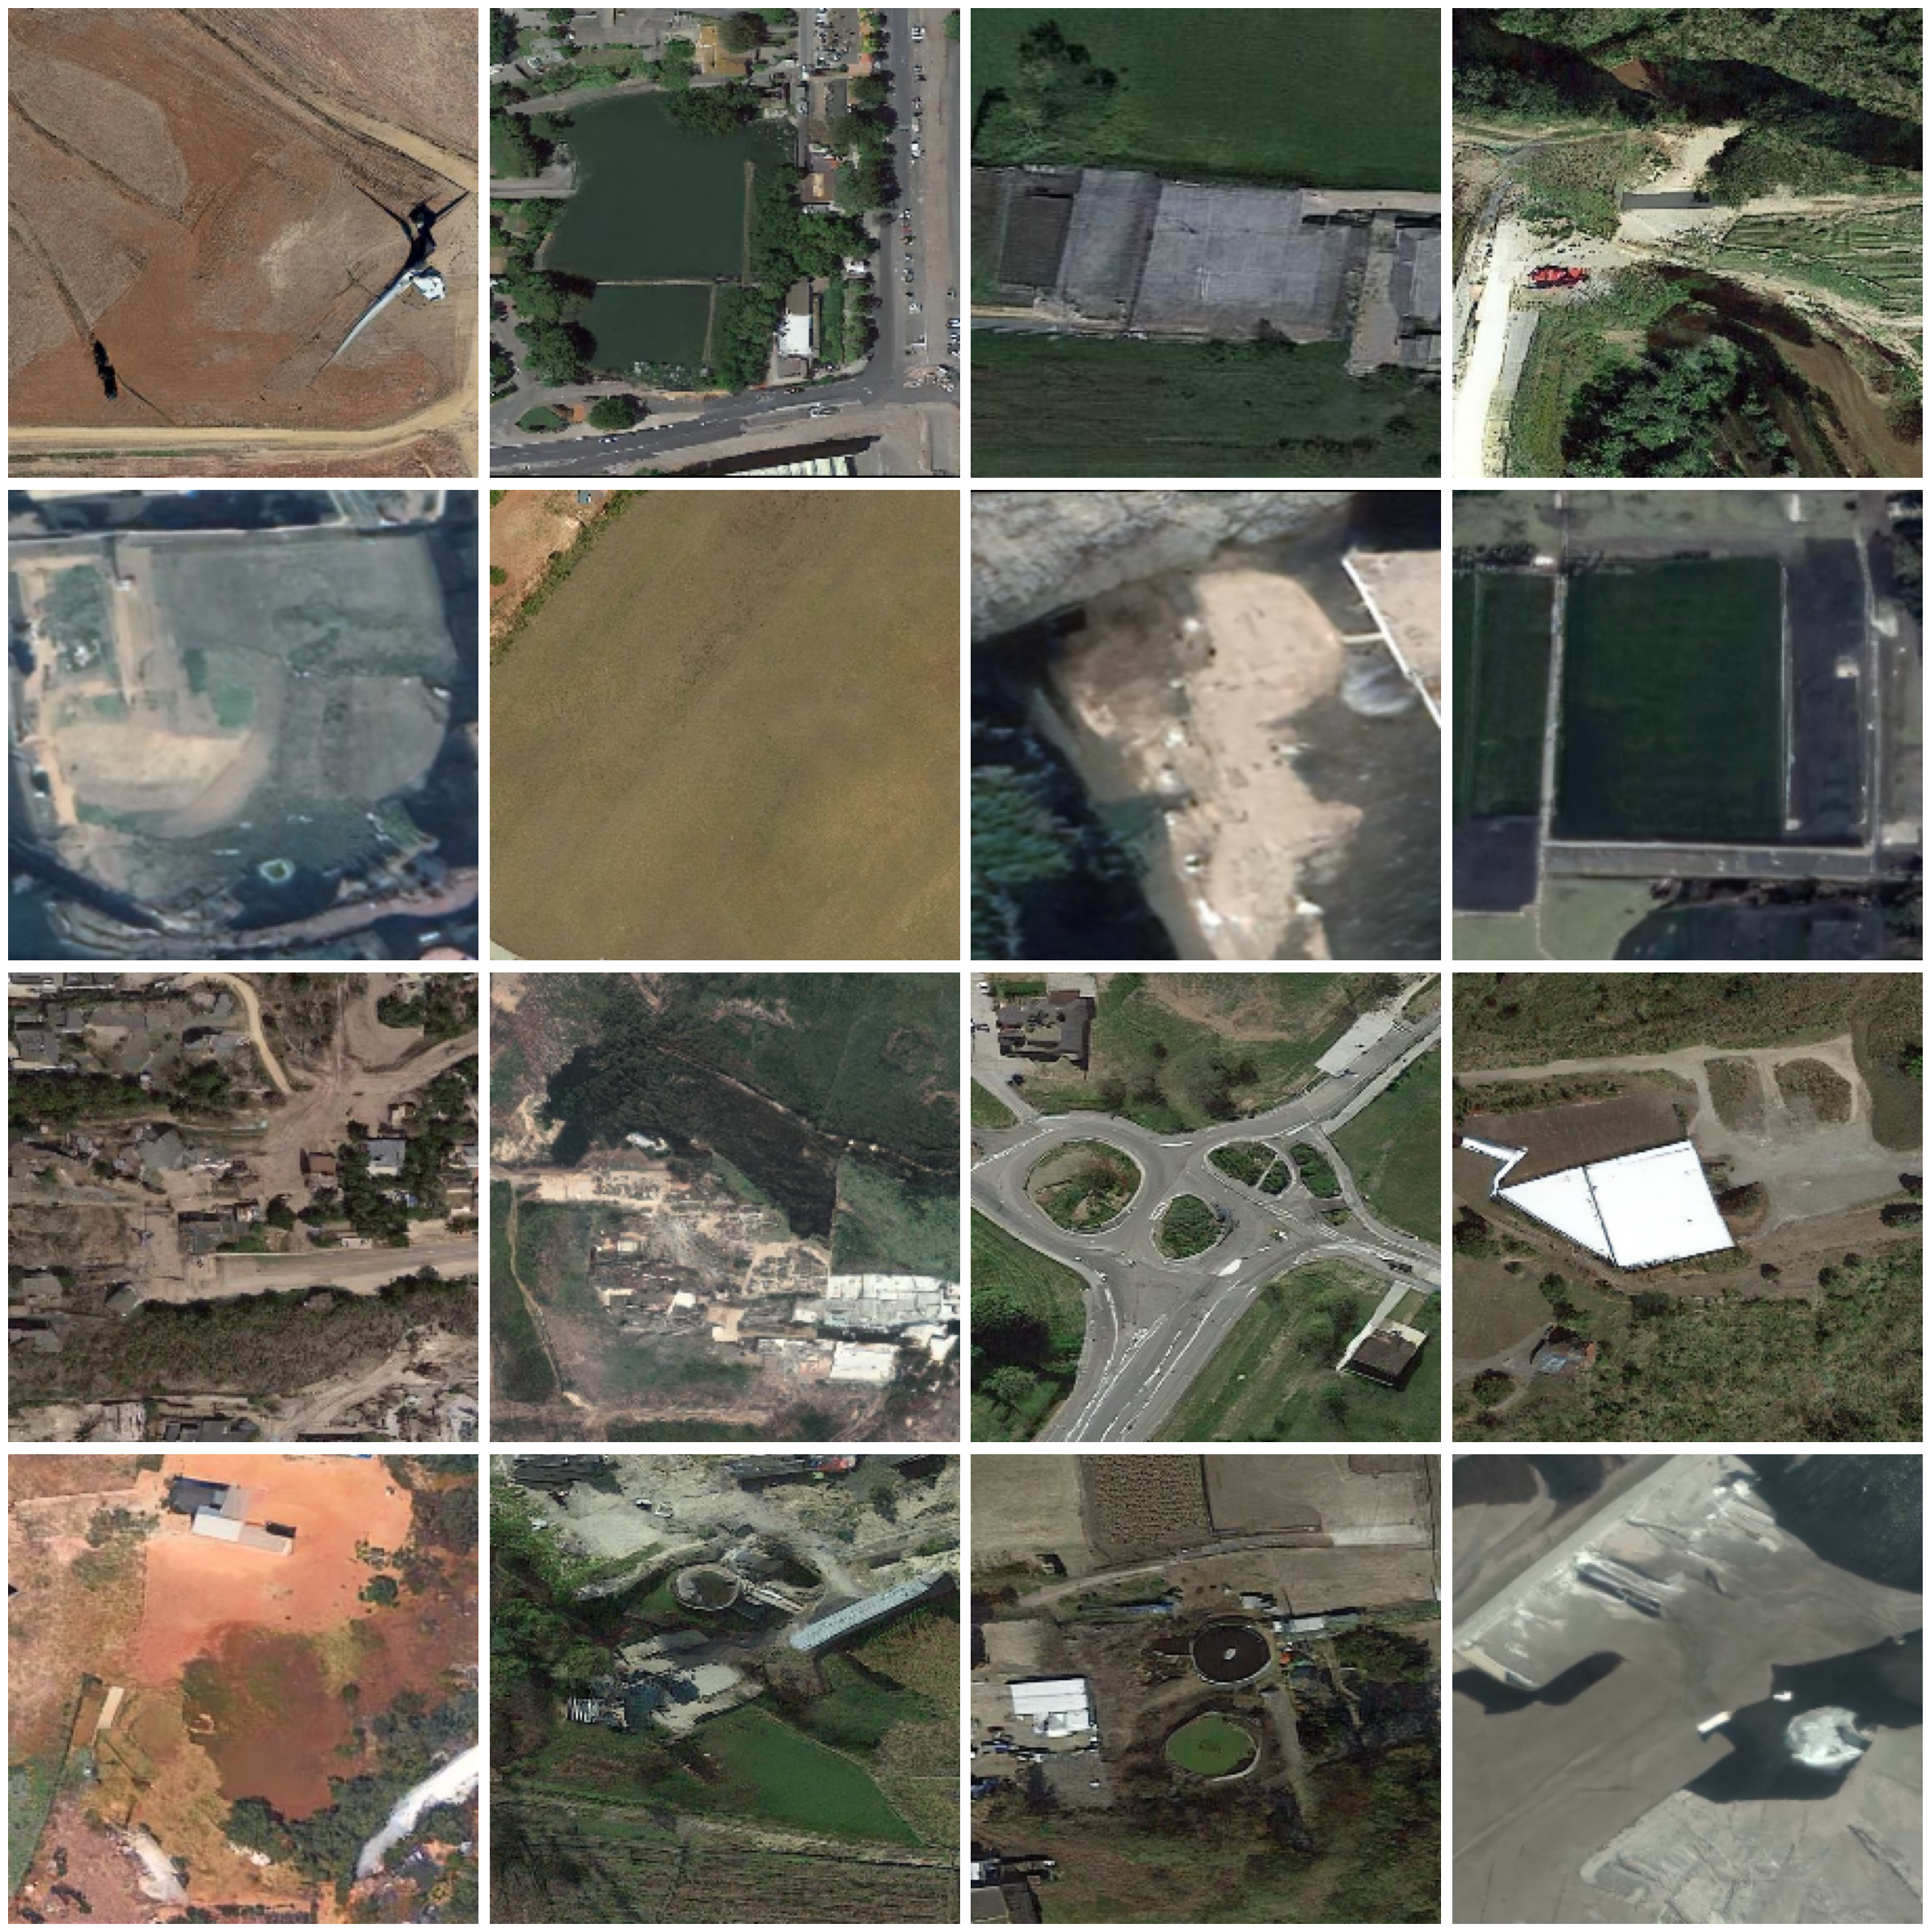

In [17]:
fig, ax = plt.subplots(4, 4, figsize=(24, 24))
for i in range(16):
    ax[i // 4, i % 4].imshow(samples[:, -1, ...][i].numpy().transpose(1, 2, 0))
    ax[i // 4, i % 4].axis("off")
plt.tight_layout()

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.notebook import tqdm

def create_gif(samples):
    """Create a GIF from the samples.

    Args:
        samples: tensor of shape [batch_size, num_timesteps, C, H, W]
    """
    batch_size, num_timesteps, C, H, W = samples.shape

    fig, axs = plt.subplots(4, 4, figsize=(24, 24))
    progress_bar = tqdm(total=num_timesteps, desc="Creating GIF")

    # Create the plots once
    imgs = []
    for j in range(16):
        img = samples[j, 0, ...].numpy().transpose(1, 2, 0)
        img_min, img_max = img.min(), img.max()
        img = (img - img_min) / (img_max - img_min)
        imgs.append(axs[j // 4, j % 4].imshow(img))

    def update(i):
        for j in range(16):
            img = samples[j, i, ...].numpy().transpose(1, 2, 0)
            # min-max normalization
            img_min, img_max = img.min(), img.max()
            img = (img - img_min) / (img_max - img_min)
            imgs[j].set_data(img)

        progress_bar.update()

    ani = animation.FuncAnimation(fig, update, frames=num_timesteps, interval=200)

    progress_bar.close()
    return HTML(ani.to_html5_video())

# Display the animation
create_gif(samples)